In [1]:
import yaml, json
import torch
import os.path as osp
import matplotlib.pyplot as plt
import math
import optuna

from nphm_tum import env_paths as mono_env_paths
from nphm_tum.models.neural3dmm import construct_n3dmm, load_checkpoint

from NPHM import env_paths
from NPHM.models.EnsembledDeepSDF import FastEnsembleDeepSDFMirrored

import numpy as np

from utils.render import render
from utils.pipeline import forward, get_latent_from_text

import clip

device = "cuda"

/home/schmid/miniconda3/envs/MonoNPHM/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ANCHORS HAVE SHAPE:  torch.Size([1, 1, 65, 3])
creating DeepSDF with...
lat dim 116
hidden_dim 400
Creating DeepSDF with input dim f119, hidden_dim f400 and output_dim 5
Loaded checkpoint from: /home/schmid/Text2Head/MonoNPHM/new_weights_mono//checkpoints/checkpoint_epoch_2500.tar


ANCHORS HAVE SHAPE:  torch.Size([1, 1, 65, 3])


creating DeepSDF with...
lat dim 116
hidden_dim 400
Creating DeepSDF with input dim f119, hidden_dim f400 and output_dim 5
Loaded checkpoint from: /home/schmid/Text2Head/MonoNPHM/new_weights_mono//checkpoints/checkpoint_epoch_2500.tar
Indices of the number 14: [17, 37, 57, 77, 95, 115, 135, 154, 182, 202]
[1, 2, 3, 4, 5]


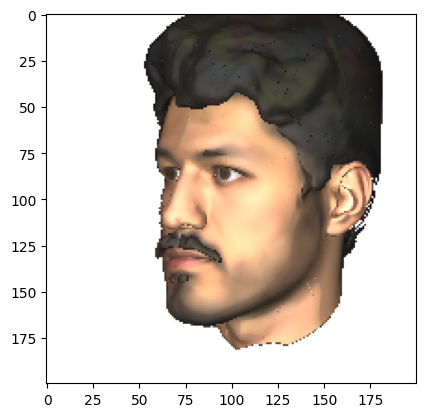

In [62]:
hparams = {
        'resolution': 160,
        'n_iterations': 20,
        'lambda': 1., #1.
        'alpha': 0.01, #0.01
        'optimizer': 'Adam',
        #'EMA_beta': 0.85,
        'optimizer_lr': 1.5e-3, #5.5e-3,
        #'grad_norm': 50.,
        'batch_size': 5,
        'lr_scheduler_factor': 0.8, 
        'lr_scheduler_patience': 5, 
        'lr_scheduler_min_lr': 3e-4,
    }

camera_params = {
        "camera_distance": 0.21 * 2.57,
        "camera_angle": 45.,
        "focal_length": 2.57,
        "max_ray_length": 3,
        # Image
        "resolution_y": 200,
        "resolution_x": 200
    }

phong_params = {
        "ambient_coeff": 0.51,
        "diffuse_coeff": 0.75,
        "specular_coeff": 0.64,
        "shininess": 0.5,
        # Colors
        "object_color": torch.tensor([0.53, 0.24, 0.64]),
        "background_color": torch.tensor([0.36, 0.77, 0.29])
    }

light_params = {
        "amb_light_color": torch.tensor([0.9, 0.16, 0.55]),
        # light 1
        "light_intensity_1": 1.42,
        "light_color_1": torch.tensor([0.8, 0.97, 0.89]),
        "light_dir_1": torch.tensor([-0.6, -0.4, -0.67]),
        # light p
        "light_intensity_p": 0.62,
        "light_color_p": torch.tensor([0.8, 0.97, 0.89]),
        "light_pos_p": torch.tensor([1.19, -1.27, 2.24])
    }

weight_dir_shape = mono_env_paths.EXPERIMENT_DIR_REMOTE + '/'
fname_shape = weight_dir_shape + 'configs.yaml'
with open(fname_shape, 'r') as f:
    CFG = yaml.safe_load(f)

# load participant IDs that were used for training
fname_subject_index = f"{weight_dir_shape}/subject_train_index.json"
with open(fname_subject_index, 'r') as f:
    subject_index = json.load(f)

# load expression indices that were used for training
fname_subject_index = f"{weight_dir_shape}/expression_train_index.json"
with open(fname_subject_index, 'r') as f:
    expression_index = json.load(f)

device = torch.device("cuda")
modalities = ['geo', 'exp', 'app']
n_lats = [len(subject_index), len(expression_index), len(subject_index)]

neural_3dmm, latent_codes = construct_n3dmm(
    cfg=CFG,
    modalities=modalities,
    n_latents=n_lats,
    device=device,
    include_color_branch=True
    )

def sdf(sdf_inputs, lat_geo, lat_exp, lat_app):
        dict_in = {
            "queries":sdf_inputs
        }

        cond = {
            "geo": torch.reshape(lat_geo, (1, 1, -1)),
            "exp": torch.reshape(lat_exp, (1, 1, -1)),
            "app": torch.reshape(lat_app, (1, 1, -1))
        }
        dict_out = neural_3dmm(dict_in, cond)
        return dict_out["sdf"], dict_out["color"]

ckpt = 2500
ckpt_path = osp.join(weight_dir_shape, 'checkpoints/checkpoint_epoch_{}.tar'.format(ckpt))
#print('Loaded checkpoint from: {}'.format(ckpt_path))
load_checkpoint(ckpt_path, neural_3dmm, latent_codes)

geo_mean = latent_codes.codebook['geo'].embedding.weight.mean(dim=0)
geo_std = latent_codes.codebook['geo'].embedding.weight.std(dim=0)
exp_mean = latent_codes.codebook['exp'].embedding.weight.mean(dim=0)
exp_std = latent_codes.codebook['exp'].embedding.weight.std(dim=0)
app_mean = latent_codes.codebook['app'].embedding.weight.mean(dim=0).detach()
app_std = latent_codes.codebook['app'].embedding.weight.std(dim=0).detach()

geo_mean = geo_mean.unsqueeze(0).unsqueeze(0)
exp_mean = exp_mean.unsqueeze(0).unsqueeze(0)

path_to_head_annotations = '../head_annotations.json'
with open(path_to_head_annotations) as f:
    data = json.load(f)

path_to_available_indentities = '../MonoNPHM/new_weights_mono/subject_train_index.json'
with open(path_to_available_indentities) as f:
    avl_ids = json.load(f)

path_to_available_indentities = '../MonoNPHM/new_weights_mono/expression_train_index.json'
with open(path_to_available_indentities) as f:
    avl_expr = json.load(f)

for head in data['heads']:
    # Extract the number from the id field
    head_number = int(head['id'].split('_')[0])  # Extracting the number part from the id
    
    # Check if the head number exists in avl_ids
    if head_number not in avl_ids:
        print(f"Head number {head_number} does not exist in available identities.")

indices = [i for i, x in enumerate(avl_expr) if x == 17][:10]
print("Indices of the number 14:", indices)

position = avl_ids.index(74)

id = latent_codes.codebook['geo'].embedding.weight[50].unsqueeze(0).unsqueeze(0)
ex = latent_codes.codebook['exp'].embedding.weight[0].unsqueeze(0).unsqueeze(0)
app = latent_codes.codebook['app'].embedding.weight[50].unsqueeze(0).unsqueeze(0)
lat_rep = [id, ex, app]

img = render(sdf, lat_rep, camera_params, phong_params, light_params)
plt.imshow(img.detach())


In [61]:
ten = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
male_ids = []
female_ids = []
young_ids = []
old_ids = []
caucasian_ids = []
asian_ids = []
ponytail_ids = []
straight_ids = []
curly_ids = []
beard_ids = []
no_beard_ids = []

for head in data['heads']:
    # Gender
    if head['gender'] == 'man':
        male_idx = int(head['id'].split('_')[0]) 
        male_ids.append(male_idx)
    if head['gender'] == 'woman':
        female_idx = int(head['id'].split('_')[0]) 
        female_ids.append(female_idx)
    
    # Age
    if head['age'] == 'young':
        young_idx = int(head['id'].split('_')[0]) 
        young_ids.append(young_idx)
    if head['age'] == 'old':
        old_idx = int(head['id'].split('_')[0]) 
        old_ids.append(old_idx)

    # Ethnicity
    if head['ethnicity'] == 'Caucasian':
        caucasian_idx = int(head['id'].split('_')[0]) 
        caucasian_ids.append(caucasian_idx) 
    if head['ethnicity'] == 'Asian':
        asian_idx = int(head['id'].split('_')[0]) 
        asian_ids.append(asian_idx)   

    # Hairstyle
    if head['hairstyle'] == 'ponytail':
        ponytail_idx = int(head['id'].split('_')[0]) 
        ponytail_ids.append(ponytail_idx)
    if head['hairstyle'] == 'straight hair':
        straight_idx = int(head['id'].split('_')[0]) 
        straight_ids.append(straight_idx)
    if head['hairstyle'] == 'curly hair':
        curly_idx = int(head['id'].split('_')[0]) 
        curly_ids.append(curly_idx)
    
    # Beard
    if head['beard'] == 'yes':
        beard_idx = int(head['id'].split('_')[0]) 
        beard_ids.append(beard_idx)
    if head['beard'] == 'no':
        no_beard_idx = int(head['id'].split('_')[0]) 
        no_beard_ids.append(no_beard_idx)

# Expression
cheeks_puffed_ids = [i for i, x in enumerate(avl_expr) if x == 15][:15]
eyes_closed_ids = [i for i, x in enumerate(avl_expr) if x == 16][:15]
brows_raised_ids = [i for i, x in enumerate(avl_expr) if x == 18][:15]

# Emotion
happy_ids = [i for i, x in enumerate(avl_expr) if x == 14][:15]
sad_ids = [i for i, x in enumerate(avl_expr) if x == 17][:15]   
    

# --- Precompute CLIP Text Embeddings ---
captions = []
prompt_man = 'A man' # 0
prompt_woman = 'A woman' # 1
prompt_young = 'A young person' # 2
prompt_old = 'An old person' # 3
prompt_caucasian = 'A Caucasian person' # 4
prompt_asian = 'An Asian person' # 5
prompt_ponytail = 'A person with a ponytail' # 8
prompt_straight = 'A person with straight hair' # 9
prompt_curly = 'A person with curly hair' # 10
prompt_beard = 'A person with beard' # 11
prompt_eyes = 'A person with closed eyes' # 14
prompt_brows = 'A person with raised brows' # 15
prompt_cheeks = 'A person with puffed cheeks' # 16
prompt_sad = 'A sad person' # 17
prompt_happy = 'A happy person' # 18


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
131
131


In [ ]:
def get_CLIP_score(id, exp, prompt, camera_params, phong_params, light_params):
    id = latent_codes.codebook['geo'].embedding.weight[id].unsqueeze(0).unsqueeze(0)
    ex = latent_codes.codebook['exp'].embedding.weight[exp].unsqueeze(0).unsqueeze(0)
    app = latent_codes.codebook['app'].embedding.weight[id].unsqueeze(0).unsqueeze(0)
    lat_rep = [id, ex, app]

    with torch.no_grad():
        CLIP_score, _, _, img = forward(lat_rep, prompt, camera_params, phong_params, light_params)

    plt.imshow(img.detach().numpy())
    plt.axis('off')  # Turn off axes
    plt.show()

    return CLIP_score

def get_mean_CLIP(camera_params, phong_params, light_params, prompt, ids, exp=None):
    CLIPS = []
    if exp == None:
        exp = [0] * len(ids)
    for i in ids:
        CLIP_score = get_CLIP_score(ids[i], exp[i], prompt, camera_params, phong_params, light_params)
        CLIPS.append(CLIP_score)
    all_CLIPS_tensor = torch.stack(CLIPS)
    mean_CLIP = torch.mean(all_CLIPS_tensor)

    return mean_CLIP

def penalty(vector, k):
    vector[vector < 0] *= k
    return vector

def analyze(hparams):
    c = {
        "camera_distance": hparams['camera_distance_factor'] * hparams['focal_length'], # ensures appropriate head size
        "camera_angle": 45.,
        "focal_length": hparams['focal_length'],
        "max_ray_length": (hparams['camera_distance_factor'] + 1) * hparams['focal_length'] + 1.5,
        # Image
        "resolution_y": 180,
        "resolution_x": 180
    }
    p = {
        "ambient_coeff": hparams['ambient_coeff'],
        "diffuse_coeff": hparams['diffuse_coeff'],
        "specular_coeff": hparams['specular_coeff'],
        "shininess": hparams['shininess'],
        # Colors
        "object_color": None,
        "background_color": hparams['background_color']
    }
    l = {
        "amb_light_color": hparams['amb_light_color'],
        # light 1
        "light_intensity_1": hparams['light_intensity_1'],
        "light_color_1": hparams['light_color'],
        "light_dir_1": hparams['light_dir_1'],
        # light p
        "light_intensity_p": hparams['light_intensity_p'],
        "light_color_p": hparams['light_color'],
        "light_pos_p": torch.tensor([hparams['light_radius_p'] * math.sqrt(1 - hparams['light_u1_p']**2) * math.cos(2*math.pi*hparams['light_u2_p']),
                                     hparams['light_radius_p'] * math.sqrt(1 - hparams['light_u1_p']**2) * math.sin(2*math.pi*hparams['light_u2_p']), 
                                     hparams['light_radius_p'] * hparams['light_u1_p']])
    }

    # Gender
    i_man = get_mean_CLIP(c, p, l, prompt_man, male_ids) - get_mean_CLIP(c, p, l, prompt_man, female_ids)
    i_woman = get_mean_CLIP(c, p, l, prompt_woman, female_ids) - get_mean_CLIP(c, p, l, prompt_woman, male_ids)
    # Age
    i_young = get_mean_CLIP(c, p, l, prompt_young, young_ids) - get_mean_CLIP(c, p, l, prompt_young, old_ids)
    i_old = get_mean_CLIP(c, p, l, prompt_old, old_ids) - get_mean_CLIP(c, p, l, prompt_old, young_ids)
    # Ethnicity
    i_caucasian = get_mean_CLIP(c, p, l, prompt_caucasian, caucasian_ids) - get_mean_CLIP(c, p, l, prompt_caucasian, asian_ids)
    i_asian = get_mean_CLIP(c, p, l, prompt_asian, asian_ids) - get_mean_CLIP(c, p, l, prompt_asian, caucasian_ids)
    # Hairstyle
    i_ponytail = get_mean_CLIP(c, p, l, prompt_ponytail, ponytail_ids) - get_mean_CLIP(c, p, l, prompt_ponytail, (straight_ids + curly_ids))
    i_straight = get_mean_CLIP(c, p, l, prompt_straight, straight_ids) - get_mean_CLIP(c, p, l, prompt_straight, (ponytail_ids + curly_ids))
    i_curly = get_mean_CLIP(c, p, l, prompt_curly, curly_ids) - get_mean_CLIP(c, p, l, prompt_curly, (ponytail_ids + straight_ids))
    # Beard
    i_beard = get_mean_CLIP(c, p, l, prompt_beard, beard_ids) - get_mean_CLIP(c, p, l, prompt_beard, no_beard_ids)
    # Expression
    e_eyes = get_mean_CLIP(c, p, l, prompt_eyes, ten, eyes_closed_ids) - get_mean_CLIP(c, p, l, prompt_eyes, ten)
    e_brows = get_mean_CLIP(c, p, l, prompt_brows, ten, brows_raised_ids) - get_mean_CLIP(c, p, l, prompt_brows, ten)
    e_cheeks = get_mean_CLIP(c, p, l, prompt_cheeks, ten, cheeks_puffed_ids) - get_mean_CLIP(c, p, l, prompt_cheeks, ten)
    # Emotion
    e_happy = get_mean_CLIP(c, p, l, prompt_happy, ten, happy_ids) - get_mean_CLIP(c, p, l, prompt_happy, ten, sad_ids)
    e_sad = get_mean_CLIP(c, p, l, prompt_sad, ten, sad_ids) - get_mean_CLIP(c, p, l, prompt_sad, happy_ids)


    i_scores = torch.stack(i_man, i_woman, i_young, i_old, i_caucasian, i_asian, i_ponytail, i_straight, i_curly, i_beard)
    e_scores = torch.stack(e_eyes, e_brows, e_cheeks, e_happy, e_sad)

    print('i_scores: ', i_scores, 'e_scores: ', e_scores)
    scores = torch.cat((i_scores, e_scores), dim=0)
    scores_penalized = penalty(scores, 10)
    scores_avg = torch.mean(scores_penalized, dim=0)
    print('scores penalized: ', scores_penalized)
    print('scores_avg: ', scores_avg)

    return scores_avg

def objective(trial):
    # Define the hyperparameters to tune and their search spaces
    search_space = {
        # Camera
        "camera_distance_factor": trial.suggest_float('camera_distance_factor', 0.1, 0.8), 
        "focal_length": trial.suggest_float('focal_length', 1.0, 5.0),
        # Phong
        "ambient_coeff": trial.suggest_float('ambient_coeff', 0.1, 1.), 
        "diffuse_coeff": trial.suggest_float('diffuse_coeff', 0.1, 1.0), 
        "specular_coeff": trial.suggest_float('specular_coeff', 0.1, 1.), 
        "shininess": trial.suggest_float('shininess', 0.1, 100, log=True),
        # Colors
        "background_color": torch.tensor([
            trial.suggest_float('background_color_0', 0.0, 1.),
            trial.suggest_float('background_color_1', 0.0, 1.),
            trial.suggest_float('background_color_2', 0.0, 1.)
        ]),
        # Light
        "amb_light_color": torch.tensor([
            trial.suggest_float('amb_light_color_0', 0.5, 1.),
            trial.suggest_float('amb_light_color_1', 0.5, 1.),
            trial.suggest_float('amg_light_color_2', 0.5, 1.)
        ]),
        # light 1
        "light_intensity_1": trial.suggest_float('light_intensity_1', 0.2, 3.0), 
        "light_color": torch.tensor([
            trial.suggest_float('light_color_0', 0.7, 1.0),
            trial.suggest_float('light_color_1', 0.7, 1.0),
            trial.suggest_float('light_color_2', 0.7, 1.0)
        ]),
        "light_dir_1": torch.tensor([
            trial.suggest_float('light_dir_1_0', -1., -0.),
            trial.suggest_float('light_dir_1_1', -1., -0.),
            trial.suggest_float('light_dir_1_2', -1., -0.)
        ]),
        # light p
        "light_intensity_p": trial.suggest_float('light_intensity_p', 0., 2.), 
        "light_radius_p": trial.suggest_float('light_radius_p', 1., 4.), 
        "light_u1_p": trial.suggest_float('light_u1_p', -1.0, 1.0),
        "light_u2_p": trial.suggest_float('light_u2_p', 0., 1.)
    }

    hparams.update(search_space)
    
    return analyze(hparams)

if __name__ == '__main__':
    study = optuna.create_study(storage="sqlite:///optuna_study_renderparams_new.db", study_name="render_params", direction='maximize', load_if_exists=True)
    study.optimize(objective, n_trials=1)
        
    best_params = study.best_params
    print(best_params)